In [1]:
import glob
import cv2, os
import matplotlib.pyplot as plt
import numpy as np

## Pré-traitement des données

In [2]:
with_train = [cv2.imread(file, 0) for file in glob.glob("train/with_mask/*.jpg")]
wout_train = [cv2.imread(file, 0) for file in glob.glob("train/without_mask/*.jpg")]

In [3]:
for i in range(len(with_train)):
    with_train[i] = cv2.resize(with_train[i], (100,100))
for i in range(len(wout_train)):
    wout_train[i] = cv2.resize(wout_train[i], (100,100))

In [4]:
X_train= np.concatenate((np.asarray(with_train, dtype=list), np.asarray(wout_train, dtype=list)), axis=0)

In [5]:
y_with_train = np.ones((len(with_train), 1), dtype = int)
y_wout_train = np.zeros((len(wout_train), 1), dtype = int)

y_train = np.concatenate((y_with_train, y_wout_train))

In [6]:
index = np.random.permutation([i for i in range(len(y_train))])

In [7]:
X_train = X_train[index]
y_train = y_train[index]

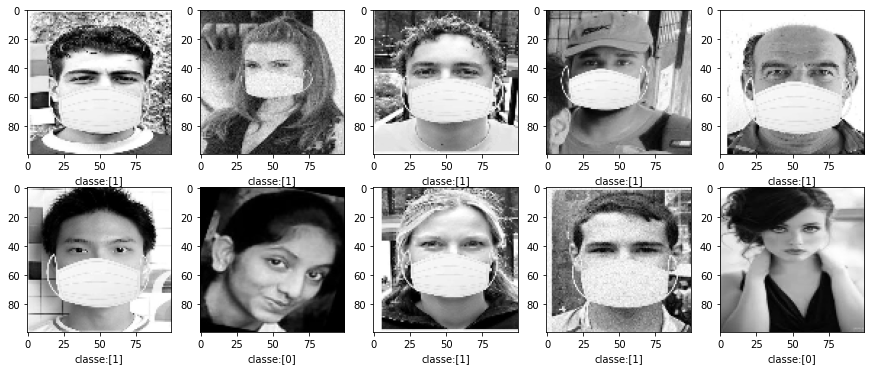

In [8]:
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(np.uint8(X_train[i]), cmap='gray')
    plt.xlabel("classe:{}".format(y_train[i]))
plt.show()

In [9]:
with_test = [cv2.imread(file, 0) for file in glob.glob("test/with_mask/*.jpg")]
wout_test = [cv2.imread(file, 0) for file in glob.glob("test/without_mask/*.jpg")]

for i in range(len(with_test)):
    with_test[i] = cv2.resize(with_test[i], (100,100))
for i in range(len(wout_test)):
    wout_test[i] = cv2.resize(wout_test[i], (100,100))
    
X_test= np.concatenate((np.asarray(with_test, dtype=list), np.asarray(wout_test, dtype=list)), axis=0)

y_with_test = np.ones((len(with_test), 1), dtype = int)
y_wout_test = np.zeros((len(wout_test), 1), dtype = int)

y_test = np.concatenate((y_with_test, y_wout_test))

index = np.random.permutation([i for i in range(len(y_test))])

index = index.astype('int')

X_test = X_test[index]
y_test = y_test[index]

In [10]:
X_test[0].shape

(100, 100)

In [11]:
X_train = X_train.reshape(X_train.shape[0], 100, 100, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 100, 1)


In [12]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

## Entrainement 

In [13]:
import tensorflow as tf

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                1

In [15]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [16]:
model.compile(loss=loss_fn,
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          batch_size=5,
          epochs=3,
          verbose=1,
)

Epoch 1/3
262/262 [==============================] - 20s 77ms/step - loss: 0.6777 - accuracy: 0.5842 - val_loss: 0.5553 - val_accuracy: 0.7526
Epoch 2/3
262/262 [==============================] - 21s 80ms/step - loss: 0.5023 - accuracy: 0.8124 - val_loss: 0.4439 - val_accuracy: 0.8608
Epoch 3/3
262/262 [==============================] - 21s 81ms/step - loss: 0.4293 - accuracy: 0.8851 - val_loss: 0.3951 - val_accuracy: 0.9227


In [18]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.3951 - accuracy: 0.9227


In [19]:
prediction = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Text(0.5, 1.0, 'Matrice de confusion')

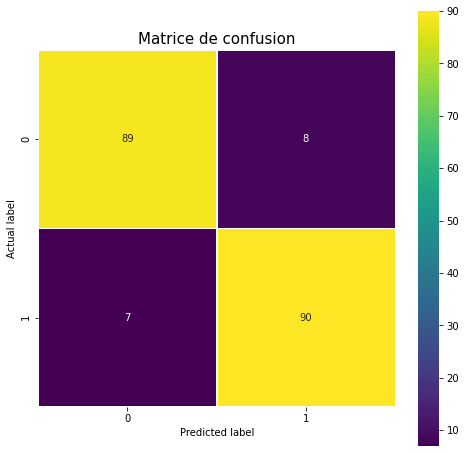

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)

import seaborn as sns

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'viridis');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Matrice de confusion", size = 15)

In [21]:
print(model.evaluate(X_test,y_test))

7/7 [==============================] - 0s 71ms/step - loss: 0.3951 - accuracy: 0.9227
[0.39512279629707336, 0.9226804375648499]


In [22]:
model.save('mask_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mask_model\assets
